# Introduction to Autoencoders (and unsupervised learning)

Goal of the lab:
* Describe basics of unsupervised learning
* Understand Autoencoders

References:
* Content heavily based on https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/404_autoencoder.ipynb (I highly recommend the whole repository)

# Whiteboard exercises

(Any left out exercises from the previous labs)

* (0.5) Explain importance of bottleneck in vanilla autoencoders, i.e. why does input have to be strictly lower than input. Describe a different way of achieving bottleneck than just reducing dimensionality (hint: lookup denoising autoencoders or contrastive autoencoders)

# Unsupervised learning as compression

(Slides from SFI 2017 talk)

## Pretraining in Deep Learning

# Autoencoders as manifold learning

(Slides from SFI 2017 talk)

## Setup

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
%matplotlib inline
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [3]:
torch.manual_seed(1)    # reproducible

In [4]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [5]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

In [7]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# Exercise 1: Finish implementation of autoencoder

In [76]:
class AutoEncoder(nn.Module):
    def __init__(self, D=3):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, D),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(D, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )
        
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

AutoEncoder (
  (encoder): Sequential (
    (0): Linear (784 -> 128)
    (1): Tanh ()
    (2): Linear (128 -> 64)
    (3): Tanh ()
    (4): Linear (64 -> 12)
    (5): Tanh ()
    (6): Linear (12 -> 3)
  )
  (decoder): Sequential (
    (0): Linear (3 -> 12)
    (1): Tanh ()
    (2): Linear (12 -> 64)
    (3): Tanh ()
    (4): Linear (64 -> 128)
    (5): Tanh ()
    (6): Linear (128 -> 784)
    (7): Sigmoid ()
  )
)
('Epoch: ', 0, '| train loss: 0.2313')


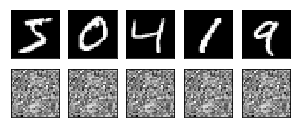

('Epoch: ', 0, '| train loss: 0.0507')


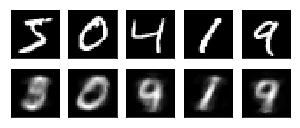

('Epoch: ', 5, '| train loss: 0.0379')


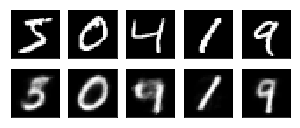

('Epoch: ', 5, '| train loss: 0.0277')


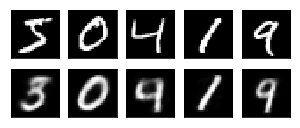

('Epoch: ', 9, '| train loss: 0.0330')


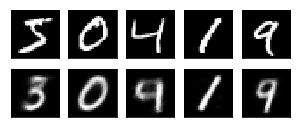

('Epoch: ', 9, '| train loss: 0.0327')


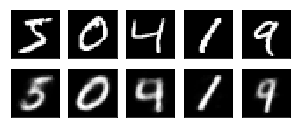

In [77]:
autoencoder = AutoEncoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0])

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); 

# Sampling from autoencoder

Theoretically speaking, we cannot sample from autoencoder. But we can! Let's generate new digits.

In [78]:
samples = []
for step, (x, y) in enumerate(train_loader):
    if len(samples) > 100:
        break
    sample = x.view(-1, 28*28)    
    enc = autoencoder.encode(Variable(sample))
    samples.append(enc.data.numpy())

In [79]:
sampled_z = np.concatenate(samples, axis=0)

In [80]:
mean_Z, std_Z = np.mean(sampled_z, axis=0), np.std(sampled_z, axis=0)

In [81]:
mean_Z

array([-0.06564204,  0.10789768,  0.06193713], dtype=float32)

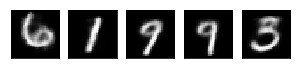

In [82]:
f, a = plt.subplots(1, N_TEST_IMG, figsize=(5, 2))
            
for i in range(N_TEST_IMG):
    z_sampled = np.random.normal(loc=mean_Z, scale=std_Z).reshape(1, -1)
    x_decoded = autoencoder.decode(Variable(torch.FloatTensor(z_sampled)))
    a[i].imshow(np.reshape(x_decoded.data.numpy(), (28, 28)), cmap='gray'); 
    a[i].set_xticks(()); 
    a[i].set_yticks(())


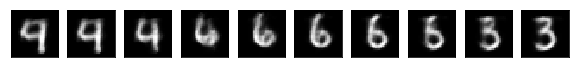

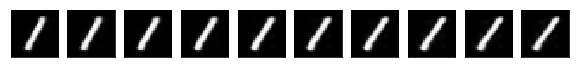

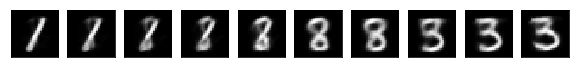

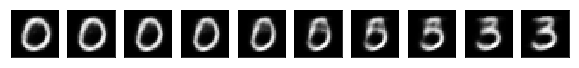

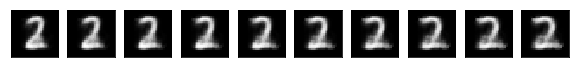

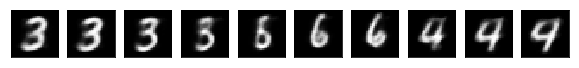

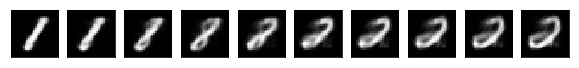

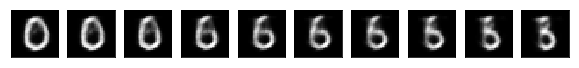

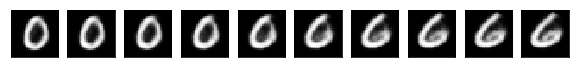

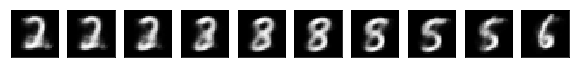

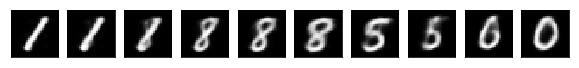

In [83]:
samples = []
for step, (x, y) in enumerate(train_loader):
    if len(samples) > 10:
        break
        
    samples.append(1)
    x_a = x[0:1, :]
    x_b = x[1:2, :]
    
    z_a = autoencoder.encode(Variable(x_a.view(-1, 28*28)))
    z_b = autoencoder.encode(Variable(x_b.view(-1, 28*28)))
    
    f, a = plt.subplots(1, 10, figsize=(10, 3))
    
    for i, alpha in enumerate(np.linspace(0, 1, 10)):
        z_int = z_a + (z_b - z_a) * alpha
        x_int = autoencoder.decode(z_int)
        a[i].imshow(np.reshape(x_int.data.numpy(), (28, 28)), cmap='gray'); 
        a[i].set_xticks(()); 
        a[i].set_yticks(())
        
    
    plt.show()
    